In [ ]:
!pip install -q transformers datasets

In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import utils # Import manually

#### **Data**

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, data: np.ndarray, feature_extractor):
    super(CustomDataset, self).__init__()
    self.data = data
    self.feature_extractor = feature_extractor

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx][:, :256, :][:, :, [2, 1, 0]]
    mask = self.data[idx][:, 256:, :][:, :, [2, 1, 0]]
    mask = utils.encoded_mask(mask)

    encoded_input = self.feature_extractor(image, mask, return_tensors="pt")
    for k, v in encoded_input.items():
      encoded_input[k].squeeze_()

    return encoded_input

In [ ]:
from transformers import SegformerFeatureExtractor

non_melanoma_data = np.load('/content/drive/MyDrive/pix2pix/Preprocessed_data_v2.npy')
feature_extractor = SegformerFeatureExtractor()

train_data = CustomDataset(non_melanoma_data[:1300, :, :, :], feature_extractor)
val_data = CustomDataset(non_melanoma_data[1300:, :, :, :], feature_extractor)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


-------------------------------------------------------------

In [ ]:
import json

id2label = {0: "A",
            1: "B",
            2: "C",
            3: "D",
            4: "E",
            5: "E",
            6: "F",
            7: "G",
            8: "H",
            9: "I",
            10: "J",
            11: "K"}
#with open('/content/drive/MyDrive/Segformer/id2label.json', 'w') as fp:
#  json.dump(id2label, fp)

label2id = {v: k for k, v in id2label.items()}

In [ ]:
encoded_inputs = train_data[899]

encoded_inputs['pixel_values'].shape, encoded_inputs['labels'].shape

(torch.Size([3, 512, 512]), torch.Size([512, 512]))

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([ 1,  4,  5,  6,  7,  8, 11])

In [ ]:
train_dataset = DataLoader(train_data, batch_size=20, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=1)

In [ ]:
for k, v in next(iter(train_dataset)).items():
  print(k, v.shape)

pixel_values torch.Size([20, 3, 512, 512])
labels torch.Size([20, 512, 512])


-----------------------------------------------------------------------

#### **Model**

In [ ]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=12,
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import load_metric
metric = load_metric('mean_iou')

<ipython-input-11-60f49aba59df>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('mean_iou')


#### **Training Loop**

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.00006)
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [ ]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
model.train()
for epoch in range(20):
  print(f"--> Epoch: {epoch}")
  for idx, batch in enumerate(tqdm(train_dataset)):
    pixel_values = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)

    with torch.cuda.amp.autocast():
      output = model(pixel_values=pixel_values, labels=labels)
      loss, logits = output.loss, output.logits

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    with torch.no_grad():
      # rescale the logits to the original image size
      rescaled_logits = nn.functional.interpolate(
          logits.detach().cpu().float(),
          size=labels.shape[-2:],
          mode="bilinear",
          align_corners=False
      )
      predicted = rescaled_logits.argmax(1)

      # metric
      metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    if idx % 100 == 0:
      metrics = metric._compute(predictions=predicted.detach().cpu().numpy(),
                                references=labels.detach().cpu().numpy(),
                                num_labels=len(id2label),
                                ignore_index=8)

      print(f"Loss: {loss.item()}")
      print("Mean_iou:", metrics["mean_iou"])
      print("Mean accuracy:", metrics["mean_accuracy"])

--> Epoch: 0


  0%|          | 0/65 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


Loss: 1.5649117231369019
Mean_iou: 0.11794174974160983
Mean accuracy: 0.19520270245741
--> Epoch: 1


  0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.9457957148551941
Mean_iou: 0.17427373067575122
Mean accuracy: 0.3024722854319645
--> Epoch: 2


  0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.7941973805427551
Mean_iou: 0.23547839625894482
Mean accuracy: 0.35427744301997577
--> Epoch: 3


  0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.726901650428772
Mean_iou: 0.21893107073809767
Mean accuracy: 0.3457736155669908


KeyboardInterrupt: ignored

#### **Inference**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
index = 1400
image, segmentation_mask = non_melanoma_data[index][:, :256, :][:, :, [2, 1, 0]], non_melanoma_data[index][:, 256:, :][:, :, [2, 1, 0]]

In [ ]:
image.shape, segmentation_mask.shape

((256, 256, 3), (256, 256, 3))

In [ ]:
# preparing the image for model
encodings = feature_extractor(image, return_tensors="pt")
pixel_values = encodings.pixel_values.to(device)
pixel_values.shape

torch.Size([1, 3, 512, 512])

In [ ]:
output = model(pixel_values=pixel_values)

In [ ]:
logits = output.logits.cpu()
logits.shape

torch.Size([1, 12, 128, 128])

In [ ]:
# Rescaling the Logits to the original size
rescaled_logit = nn.functional.interpolate(
    logits,
    size=image[:, :, -1].shape,
    mode='bilinear',
    align_corners=False
)

seg_msk = rescaled_logit.argmax(1)[0]
color_seg = utils.decoded_mask(seg_msk)

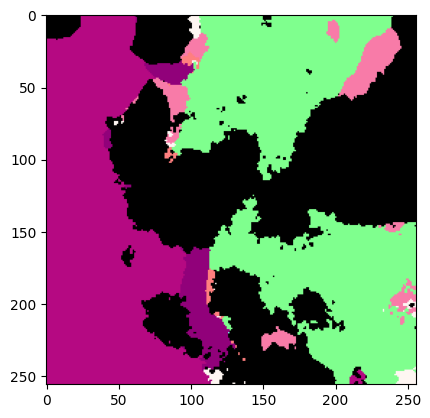

In [ ]:
plt.imshow(color_seg)

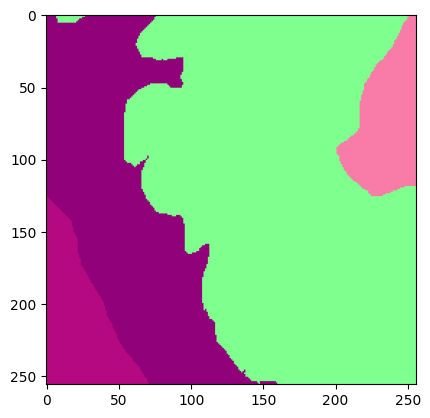

In [ ]:
plt.imshow(segmentation_mask)

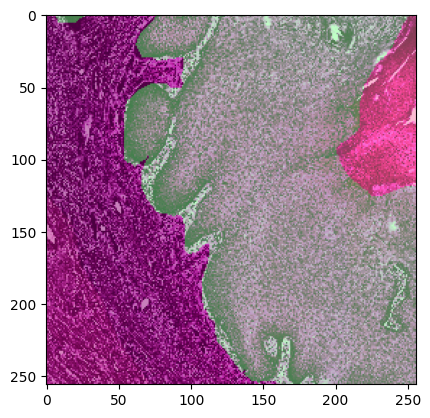

In [ ]:
img = image *0.5 + segmentation_mask * 0.5
img = img.astype(np.uint8)
plt.imshow(img)